In [1]:
import autograd.numpy as np
import numpy as pure_np
import autograd
import scipy.sparse as spsp
import scipy.sparse.linalg as spsplin
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import pyamg
import copy

## Generate matrix with PyAMG and compute spectral radius with the default parameters

In [2]:
n = 63
num_levels = 5
grid_size = (n, n)

In [3]:
h = 1. / (n+1)
eps = 5e-3
A = pyamg.gallery.stencil_grid(np.array([[0, - eps - h, 0], 
                                         [-h - eps, 4. * eps + h * 2, - eps],
                                         [0, - eps, 0]]), 
                               grid_size, format="csr")

# A = pyamg.gallery.stencil_grid(np.array([-eps, 2*eps - h, -eps + h]), (n, ), format="csr") # Instable!
# A = pyamg.gallery.stencil_grid(np.array([-eps - h, 2*eps + h, -eps]), grid_size, format="csr")

In [4]:
print(A.min(), A.max())

-0.020625 0.051250000000000004


In [5]:
if len(grid_size) == 1:
    x_range = np.linspace(0, 1, num=n+2)
    x_range = x_range[1:-1]
    x_true = np.sin(np.pi * x_range)
    rhs = (eps * np.pi**2 * x_true + np.pi * np.cos(np.pi * x_range)) / (n+1)**2
    rhs = rhs.reshape(A.shape[0], 1)
elif len(grid_size) == 2:
    x0 = np.zeros((A.shape[0], 1))
    x_range = np.linspace(0, 1, num=n+2)
    x_range = x_range[1:-1]

    x_range, y_range = np.meshgrid(x_range, x_range)
    x_true = np.sin(np.pi * x_range) * np.sin(np.pi * y_range)
    rhs = (2 * np.pi**2 * x_true * eps + np.pi * np.sin(np.pi * (x_range + y_range))) / (n+1)**2
    rhs = rhs.reshape(A.shape[0], 1)
rhs.shape

(3969, 1)

In [6]:
ml = pyamg.ruge_stuben_solver(A, CF="RS", max_levels=num_levels, 
                             presmoother=('jacobi', {'omega': 2.0/3.0, 'iterations': 2, "withrho": False}),
                             postsmoother=('jacobi', {'omega': 2.0/3.0, 'iterations' : 2, "withrho": False})
                             )


print(ml)
num_levels = len(ml.levels)

multilevel_solver
Number of Levels:     5
Operator Complexity:  3.667
Grid Complexity:      2.087
Coarse Solver:        'pinv2'
  level   unknowns     nonzeros
    0         3969        19593 [27.27%]
    1         2196        17596 [24.49%]
    2         1210        15013 [20.89%]
    3          598        11600 [16.14%]
    4          309         8053 [11.21%]



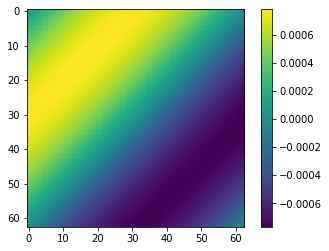

In [7]:
if len(grid_size) == 1:
    plt.plot(rhs.ravel())
elif len(grid_size) == 2:
    plt.imshow(rhs.reshape(n, n))
    plt.colorbar()

In [8]:
x = ml.solve(rhs, tol=1e-10)
x = x[:, np.newaxis]

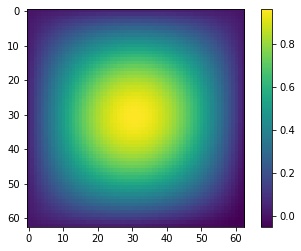

In [9]:
if len(grid_size) == 1:
    plt.plot(x)
elif len(grid_size) == 2:
    plt.imshow(x.reshape(n, n))
    plt.colorbar()

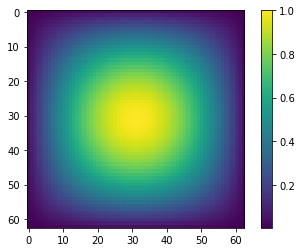

In [10]:
if len(grid_size) == 1:
    plt.plot(x_true)
elif len(grid_size) == 2:
    plt.imshow(x_true)
    plt.colorbar()

In [11]:
print("Residual norm = {}".format(np.linalg.norm(rhs-A.dot(x))))
if len(grid_size) == 2:
    print("Error = {}".format(np.linalg.norm(x_true - x.reshape(n, n))/np.linalg.norm(x_true.ravel())))
elif len(grid_size) == 1:
    print("Error = {}".format(np.linalg.norm(x_true - x.ravel()) / np.linalg.norm(x_true.ravel())))

Residual norm = 3.045839856342835e-12
Error = 0.06235299314862041


In [12]:
for l in ml.levels[:-1]:
    print(l.R.shape, l.A.shape, l.P.shape)
    print(l.A.min(), l.A.max())
print(ml.levels[-1].A.shape, ml.levels[-1].A.min(), ml.levels[-1].A.max())

(2196, 3969) (3969, 3969) (3969, 2196)
-0.020625 0.051250000000000004
(1210, 2196) (2196, 2196) (2196, 1210)
-0.02263719512195122 0.05423780487804877
(598, 1210) (1210, 1210) (1210, 598)
-0.022036421041613546 0.06577840933822782
(309, 598) (598, 598) (598, 309)
-0.029068866421814145 0.10623507075684671
(309, 309) -0.046493619132442335 0.1361876565930362


In [13]:
def compute_spectral_radius_pyamg(pyamg_solver):
    n = pyamg_solver.levels[0].A.shape[0]
    M = spsplin.LinearOperator((n, n), 
                               matvec=lambda x: pyamg_solver.solve(np.zeros((n, 1)), x0=x, maxiter=1))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [14]:
pyamg_rho = compute_spectral_radius_pyamg(ml)
print("Spectral radius for default parameters = {}".format(pyamg_rho))

Spectral radius for default parameters = 0.4368505856849151


## Custom implementation of V-cycle

In [15]:
import csr_compatible_primitives as csr_prim

In [16]:
def jacobi_smooth_sparse(A_values, A_indices, A_indptr, x0, b, w):
    x = x0
    n = x.shape[0]
    d = csr_prim.get_sparse_diag(A_values, A_indices, A_indptr, n)
    for i in range(2):
        Ax = csr_prim.csr_matvec(A_values, A_indptr, A_indices, x)
#         print(Ax.shape, b.shape, x.shape)
        x = x - w * (Ax - b) / d
    return x

In [17]:
def csr2dense(values, indices, indptr, n_col):
    n_row = indptr.shape[0] - 1
#     print("Number of rows", n_row)
#     print(values)
    A = pure_np.zeros((n_row, n_col))
    for i in range(n_row):
        for j in range(indptr[i], indptr[i+1]):
            A[i, indices[j]] = values[j]
#     print(A)
    return A

In [18]:
def V_cycle(x0, b, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=1, w=2.0/3.0):
    x = x0
    if level == 0:
        A_full = csr_prim.csr2dense(A_values[level], A_coarse_indices, A_coarse_indptr, A_coarse_indptr.shape[0] - 1)
#         print("Norm of dense mat", np.linalg.norm(A_full))
        x = np.linalg.solve(A_full, b)
    else:
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
        Ax = csr_prim.csr_matvec(A_values[level], A_indptr[level], A_indices[level], x)
        res = b - Ax
        proj_res = csr_prim.csr_matvec(R_values[level], R_indptr[level], R_indices[level], res)
        e = np.zeros_like(proj_res)
        u = V_cycle(e, proj_res, A_values[:-1], A_indptr[:-1], A_indices[:-1],
                    P_values[:-1], P_indptr[:-1], P_indices[:-1], 
                    R_values[:-1], R_indptr[:-1], R_indices[:-1], 
                    level-1, w)
        Pu = csr_prim.csr_matvec(P_values[level], P_indptr[level], P_indices[level], u)
        x = x + Pu
        x = jacobi_smooth_sparse(A_values[level], A_indices[level], A_indptr[level], x, b, w)
    return x

In [19]:
A_list = [l.A.sorted_indices() for l in ml.levels]
# for A in A_list:
#     print(A.shape)

In [20]:
P_list = [l.P.sorted_indices() for l in ml.levels[:-1]]
# for P in P_list:
#     print(P.shape)

In [21]:
R_list = [l.R.sorted_indices() for l in ml.levels[:-1]]
# for R in R_list:
#     print(R.shape)

In [22]:
A_values = [A.data for A in A_list[::-1]]
A_indices = [A.indices for A in A_list[::-1]]
A_indptr = [A.indptr for A in A_list[::-1]]
A_coarse_indices = copy.copy(A_indices[0])
A_coarse_indptr = copy.copy(A_indptr[0])

In [23]:
P_values = [[]] + [P.data for P in P_list[::-1]]
P_indices = [[]] + [P.indices for P in P_list[::-1]]
P_indptr = [[]] + [P.indptr for P in P_list[::-1]]

In [24]:
R_values = [[]] + [R.data for R in R_list[::-1]]
R_indices = [[]] + [R.indices for R in R_list[::-1]]
R_indptr = [[]] + [R.indptr for R in R_list[::-1]]

In [25]:
x = np.zeros((A.shape[0], 1))
for i in range(10):
    x = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                       P_values, P_indptr, P_indices,
                       R_values, R_indptr, R_indices,
                       level=num_levels-1, w=2.0/3.0)
    print(np.linalg.norm(A.dot(x) - rhs))

0.0131998903432835
0.004531894657965775
0.001637904963833009
0.0006760278631025171
0.0002764277871905562
0.00011248686455875614
4.871010379851203e-05
2.101470049235952e-05
8.831072134359403e-06
3.837548292460476e-06


## Compare hierarchy with PyAMG

In [26]:
def csr_3mat(A_data, A_indptr, A_indices, 
               B_data, B_indptr, B_indices, 
               C_data, C_indptr, C_indices,
               D_ref_indices, D_ref_indptr,
               m, n, k, l):
    A_csr = spsp.csr_matrix((A_data, A_indices, A_indptr), shape=(m, n))
    B_csr = spsp.csr_matrix((B_data, B_indices, B_indptr), shape=(n, k))
    C_csr = spsp.csr_matrix((C_data, C_indices, C_indptr), shape=(k, l))
#     print(A_csr.dtype, B_csr.dtype, C_csr.dtype)
    D_csr = A_csr.dot(B_csr).dot(C_csr)
    D_csr.eliminate_zeros()
    D_csr.sort_indices()
    D_data = D_csr.data
    if D_ref_indices.shape[0] != D_csr.data.shape[0]:
#         print("Compare indices")
#         print(D_ref_indptr - D_csr.indptr)
#         print(D_csr.indptr)
        D_data = prune_csr_matrix(D_ref_indptr, D_ref_indices, D_csr.indptr, D_csr.indices, D_csr.data)
#         print(np.linalg.norm(D_data))
#     D_csr = spsp.csr_matrix((D_data, copy.copy(D_ref_indices), copy.copy(D_ref_indptr)), shape=(m, l))
#     D_csr.sort_indices()
#     D_data = D_csr.data
    return D_data

In [27]:
def prune_csr_matrix(ref_indptr, ref_indices,
                     pruned_indptr, pruned_indices, pruned_data):
    A_grad = pure_np.zeros((ref_indices.shape[0], ))
    value_counter = 0
    for i in range(ref_indptr.shape[0] - 1):
        num_col = len(ref_indices[ref_indptr[i]:ref_indptr[i+1]])
        for k in range(ref_indptr[i], ref_indptr[i+1]):
            for j in range(pruned_indptr[i], pruned_indptr[i+1]):
                if ref_indices[k] == pruned_indices[j]:
                    A_grad[k] = pruned_data[j]
        value_counter += num_col
    return A_grad

In [28]:
def generate_all_A(A_csr_value, A_csr_indices, A_csr_indptr, 
                   P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   RAP_list_indices, RAP_list_indptr, level=1):
    
    A_values = [[] for i in range(level+1)]
    A_indices = RAP_list_indices[:-1] + [A_csr_indices]
    A_indptr = RAP_list_indptr[:-1] + [A_csr_indptr]
#     for A_ in A_indptr:
#         print(A_.shape)
#     for R_ in R_indptr:
#         print("R row", len(R_))
    A_values[level] = A_csr_value
#     A_indices[level] = A_csr_indices
#     A_indptr[level] = A_csr_indptr
    
    for l in range(level-1, -1, -1):
#         print("Level", l)
        n = A_indptr[l+1].shape[0] - 1
#         print("Matrix A dim", n)
        
        n_coarse = R_indptr[l+1].shape[0] - 1
#         print("R info", R_values[l+1].shape)
#         print("A info", A_values[l+1].shape)
#         print("P info", P_values[l+1].shape)
        A_values[l], _, _ = csr_prim.csr_3mat(R_values[l+1], R_indptr[l+1], R_indices[l+1], 
                                     A_values[l+1], A_indptr[l+1], A_indices[l+1], 
                                     P_values[l+1], P_indptr[l+1], P_indices[l+1],
                                     A_indices[l], A_indptr[l],
                                     n_coarse, n, n, n_coarse)
#         print("norm of val", np.linalg.norm(A_values[l+1]))
#         print("Min A element in level {} = {}".format(l, np.min(abs(A_values[l]))))
#         print(A_values[l].shape, A_indices[l].shape)
#     print("norm of val", np.linalg.norm(A_values[0]))
    return A_values, A_indices, A_indptr

In [29]:
trial_A_values, trial_A_indices, trial_A_indptr = generate_all_A(A.data, A.indices, A.indptr, P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   A_indices, A_indptr, num_levels-1)

In [30]:
for A_val_, A_indices_, A_inptr_ in zip(trial_A_values, trial_A_indices, trial_A_indptr):
    temp_A = spsp.csr_matrix((A_val_, A_indices_, A_inptr_))
#     print(spsplin.norm(temp_A - ))

### Compare spectral radius with PyAMG

In [31]:
def multigrid_matvec(x, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    
    rhs = np.zeros((A_indptr[-1].shape[0] - 1, 1))
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    y = V_cycle(x, rhs, A_values, A_indptr, A_indices, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w)
    return y

def compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level, w):
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, P_values, P_indices, P_indptr, 
                   R_values, R_indices, R_indptr,
                   A_indices, A_indptr, level)
    M = spsplin.LinearOperator((A_indptr_[-1].shape[0] - 1, A_indptr_[-1].shape[0] - 1), 
                               matvec=lambda x: multigrid_matvec(x, A_values, A_indptr_, A_indices_, 
                                               P_values, P_indptr, P_indices,
                                               R_values, R_indptr, R_indices,
                                               level, w))
    rho = spsplin.eigs(M, k=1, return_eigenvectors=False, which="LM")[0]
    return abs(rho)

In [32]:
compute_spectral_radius_multigrid(A, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   level=num_levels-1, w=2./3)

0.4368505856849123

## Define all for optimization

In [33]:
def v_cycle_objective(R_values_active, P_values_active, w, x, num_levels):
    K = 10
    rhs = np.zeros((A.shape[0], num_trials))
    P_values = [[]] + P_values_active
    R_values = [[]] + R_values_active
    A_values, A_indices_, A_indptr_ = generate_all_A(A.data, A.indices, A.indptr, 
                                                   P_values, P_indices, P_indptr, 
                                                   R_values, R_indices, R_indptr,
                                                   A_indices, A_indptr, 
                                                   num_levels)
    for i in range(K):
        x = V_cycle(x, rhs, A_values, A_indptr_, A_indices_, 
                   P_values, P_indptr, P_indices,
                   R_values, R_indptr, R_indices,
                   num_levels, w)
    loss = np.linalg.norm(x, "fro")**2
    return np.log(loss)

In [34]:
R_values_active = [R.data for R in R_list[::-1]]
P_values_active = [P.data for P in P_list[::-1]]
w = 2./3
num_trials = 5
x_batch = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
v_cycle_objective(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

-12.501344784571955

In [35]:
grad = autograd.grad(v_cycle_objective, 0)

In [36]:
grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

[array([-1.25914199e-03, -4.40197837e-03,  1.46528708e-03, ...,
        -1.18164426e-05, -2.80044332e-05,  1.40735026e-05]),
 array([ 3.17402818e-03,  6.23134757e-04, -2.92734182e-03, ...,
        -4.23568185e-05,  1.67459562e-06,  7.38170352e-05]),
 array([ 5.52311533e-04, -4.74897503e-04,  9.01227418e-04, ...,
         6.93197491e-06, -1.33489261e-06,  3.44794232e-06]),
 array([ 1.18708670e-03, -3.60174250e-04, -1.11073753e-03, ...,
         2.00657223e-05,  9.64536641e-06, -3.38766251e-06])]

In [37]:
# %timeit grad(R_values_active, P_values_active, w, x_batch, num_levels=num_levels-1)

### Optimization utilities

In [38]:
from autograd.misc import flatten
from autograd.wrap_util import wraps

def unflatten_optimizer(optimize):
    """Takes an optimizer that operates on flat 1D numpy arrays and returns a
    wrapped version that handles trees of nested containers (lists/tuples/dicts)
    with arrays/scalars at the leaves."""
    @wraps(optimize)
    def _optimize(grad, x0, callback=None, *args, **kwargs):
        _x0, unflatten = flatten(x0)
        _grad = lambda x, i: flatten(grad(unflatten(x), i))[0]
        if callback:
            _callback = lambda x, i, g, num_iter, *args, **kwargs: callback(unflatten(x), i, unflatten(g), num_iter, *args, **kwargs)
        else:
            _callback = None
        return unflatten(optimize(_grad, _x0, _callback, *args, **kwargs))

    return _optimize

In [39]:
@unflatten_optimizer
def adam(grad, x, callback=None, num_iters=100,
         step_size=0.001, b1=0.9, b2=0.999, eps=10**-8, *args, **kwargs):
    """Adam as described in http://arxiv.org/pdf/1412.6980.pdf.
    It's basically RMSprop with momentum and some correction terms."""
    m = np.zeros(len(x))
    v = np.zeros(len(x))
    for i in range(num_iters):
#         print(i)
#         print(x.shape)
        g = grad(x, i)
        if callback: callback(x, i, g, num_iters, *args, **kwargs)
        m = (1 - b1) * g      + b1 * m  # First  moment estimate.
        v = (1 - b2) * (g**2) + b2 * v  # Second moment estimate.
        mhat = m / (1 - b1**(i + 1))    # Bias correction.
        vhat = v / (1 - b2**(i + 1))
        x = x - step_size*mhat/(np.sqrt(vhat) + eps)
    return x

In [44]:
def my_test_callback(params, current_iter, gradient, num_iters):
    if current_iter == 0 or (current_iter + 1) % 10 == 0:
        print("Iteration {}".format(current_iter + 1))
#         print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
#                    [[]] + params[1], P_indptr, P_indices,
#                    [[]] + params[0], R_indptr, R_indices,
#                    num_levels-1, params[2])))
        u = np.random.randint(0, 2, size=(A.shape[0], num_trials))
        u = 2 * u - 1
        print("Current objective value = {}".format(v_cycle_objective(params[0], params[1], params[2], 
                                                                      u, num_levels=num_levels-1)))

In [48]:
def obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return objective(param[0], param[1], param[2], x)

def v_cycle_obj(param, n_iter):
    x = 2 * np.random.randint(0, 2, (A.shape[0], num_trials)) - 1
    return v_cycle_objective(param[0], param[1], param[2], x, num_levels=num_levels-1)

grad_v_cycle_obj = autograd.grad(v_cycle_obj)
num_iters = 1000
step_size = 5e-4

In [49]:
# grad_v_cycle_obj((R_values_active, P_values_active, w), 0)

In [50]:
PRd_opt = adam(grad_v_cycle_obj, (R_values_active, P_values_active, w), my_test_callback, num_iters, step_size, 0.9, 0.999, 10**-8)

Iteration 1
Current objective value = -12.520919624816583
Iteration 10
Current objective value = -15.241029718832372
Iteration 20
Current objective value = -16.806725635785806
Iteration 30
Current objective value = -18.095610180024117
Iteration 40
Current objective value = -18.934272338214686
Iteration 50
Current objective value = -19.951955850677063
Iteration 60
Current objective value = -20.813888938995145
Iteration 70
Current objective value = -21.406517263407395
Iteration 80
Current objective value = -22.14607512681299
Iteration 90
Current objective value = -23.135876061106902
Iteration 100
Current objective value = -23.830376492830155
Iteration 110
Current objective value = -24.508433693675077
Iteration 120
Current objective value = -24.937043843278257
Iteration 130
Current objective value = -25.696928396800974
Iteration 140
Current objective value = -26.125138690034376
Iteration 150
Current objective value = -26.587243200064005
Iteration 160
Current objective value = -26.65048946

In [51]:
print("Spectral radius = {}".format(compute_spectral_radius_multigrid(A, 
                   [[]] + PRd_opt[1], P_indptr, P_indices,
                   [[]] + PRd_opt[0], R_indptr, R_indices,
                   num_levels-1, PRd_opt[2])))

Spectral radius = 0.11958609219828446
